In [1]:
import laspy
import open3d as o3d
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import pandas as pd
import seaborn as sns

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset= r'data/input/u_3735069800.las'
las = laspy.read(dataset)
buildings = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
buildings.points = las.points[las.classification == 6]

x = buildings.points.X
y = buildings.points.Y
z = buildings.points.Z

intensity = buildings.intensity

bp_data = np.stack([buildings.points.X, buildings.points.Y, buildings.points.Z], axis=0).transpose((1, 0))

In [3]:
bp_data

array([[373552944,    722946,    303465],
       [373554316,    722930,    303853],
       [373554856,    722488,    304005],
       ...,
       [374993958,   -745215,    125682],
       [374994980,   -744599,    125738],
       [374994324,   -744251,    125682]])

In [4]:
geom = o3d.geometry.PointCloud() # find a way to color each point in accordance with its classification code
geom.points = o3d.utility.Vector3dVector(bp_data)
o3d.visualization.draw_geometries([geom])

Text(0, 0.5, 'Z-axis')

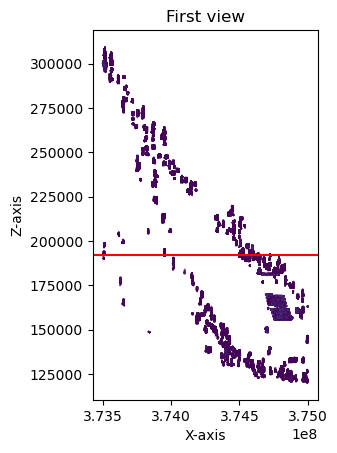

In [5]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(x, z, c=intensity, s=0.05)
plt.axhline(y=np.mean(z), color='r', linestyle='-')
plt.title('First view')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')

Text(0, 0.5, 'Z-axis')

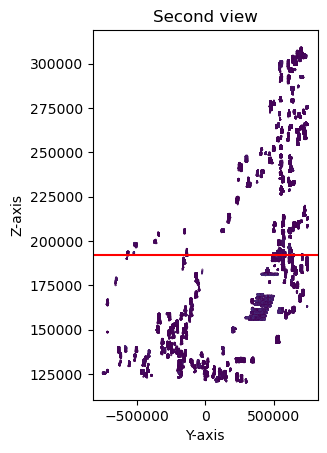

In [6]:
plt.subplot(1, 2, 2) # index 2
plt.scatter(y, z, c=intensity, s=0.05)
plt.axhline(y=np.mean(z), color='r', linestyle='-')
plt.title('Second view')
plt.xlabel('Y-axis')
plt.ylabel('Z-axis')

In [7]:
pcd=np.column_stack((x,y,z))
mask=z>np.mean(z)
spatial_query=pcd[z>np.mean(z)]

In [8]:
pcd.shape==spatial_query.shape 

False

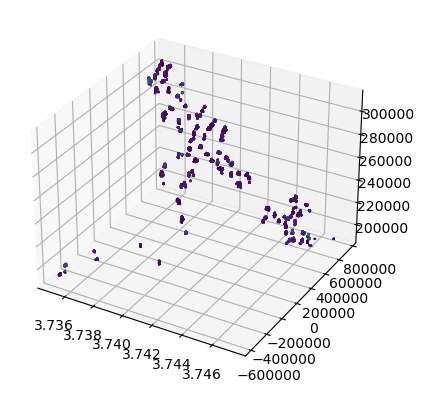

In [9]:
#plotting the results 3D
ax = plt.axes(projection='3d')
ax.scatter(x[mask], y[mask], z[mask], c = intensity[mask], s=0.1)
plt.show()

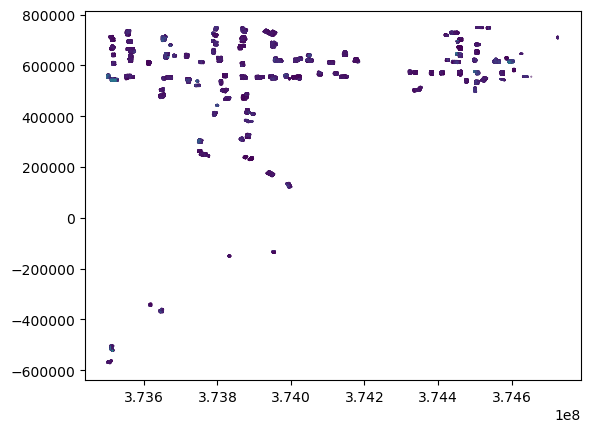

In [10]:
#plotting the results 2D
plt.scatter(x[mask], y[mask], c=intensity[mask], s=0.1)
plt.show()

In [11]:
X=np.column_stack((x[mask], y[mask]))
X_all = np.column_stack((x[mask], y[mask], z[mask]))

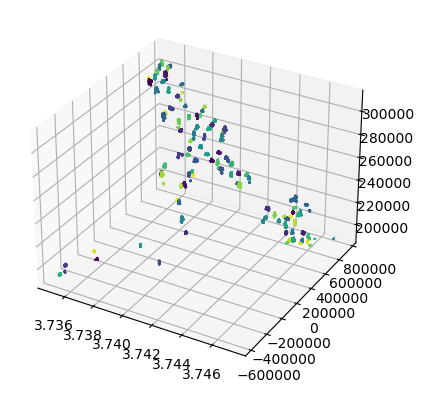

In [12]:
kmeans = KMeans(n_clusters=100).fit(X) # adjust n_clusters
# plt.scatter(x[mask], y[mask], c=kmeans.labels_, s=0.1)
# plt.show()
ax = plt.axes(projection='3d')
ax.scatter(x[mask], y[mask], z[mask], c = kmeans.labels_, s=0.1)
plt.show()

In [13]:
df = pd.DataFrame(X_all, columns = ['x', 'y','z'])
clust_labels = kmeans.labels_
df['label'] = clust_labels
# list(set(df['label']))
df_cluster1 = df[df['label'] == 1]
cluster1 = df_cluster1[["x","y","z"]].to_numpy()
cluster1

df_cluster87 = df[df['label'] == 87]
cluster87 = df_cluster87[["x","y","z"]].to_numpy()
cluster87

df_cluster32 = df[df['label'] == 32]
cluster32 = df_cluster32[["x","y","z"]].to_numpy()
cluster32

df_cluster2 = df[df['label'] == 2]
cluster2 = df_cluster2[["x","y","z"]].to_numpy()
cluster2

array([[373941640,    560932,    242870],
       [373941492,    561062,    242902],
       [373942372,    561896,    243042],
       ...,
       [373960510,    545852,    243162],
       [373960548,    546322,    243278],
       [373961066,    546366,    243300]])

In [14]:
lstx = [item[0] for item in cluster87]
lsty = [item[1] for item in cluster87]
lstz = [item[2] for item in cluster87]

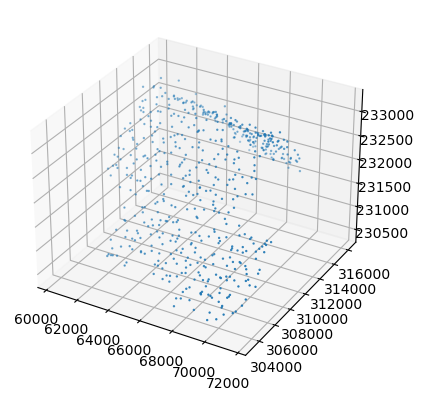

In [15]:
#plotting the results 3D
ax = plt.axes(projection='3d')
ax.scatter(lstx, lsty, lstz, s=0.5)
plt.show()

## Ball Pivot

In [16]:
geom = o3d.geometry.PointCloud() # find a way to color each point in accordance with its classification code
geom.points = o3d.utility.Vector3dVector(cluster87)
o3d.visualization.draw_geometries([geom])

In [18]:
geom = o3d.geometry.PointCloud() # filters out specifically buildings
geom.points = o3d.utility.Vector3dVector(cluster87[:,:3])

#geom.colors =  o3d.utility.Vector3dVector(building_point_data / 255.0)
geom.normals = o3d.utility.Vector3dVector(cluster87)
o3d.visualization.draw_geometries([geom])

np_points = np.asarray(geom.normals)
pcd = geom.normals

#geom.colors = o3d.utility.Vector3dVector(point_data[:,3:6]/255)
#geom.normals = do.estimate_normals(
 #   search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = pcd

distances = geom.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 200 * avg_dist # scale radius value

print(type(geom))
print(type(pcd))

<class 'open3d.cpu.pybind.geometry.PointCloud'>
<class 'open3d.cpu.pybind.utility.Vector3dVector'>


In [19]:
o3d.visualization.draw_geometries([point_cloud])

In [20]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(geom,o3d.utility.DoubleVector([radius, radius * 2]))

In [21]:
o3d.visualization.draw_geometries([bpa_mesh])

In [22]:
input_path = r'input'
output_path = r'output'
o3d.io.write_triangle_mesh(output_path+"bpa_mesh.ply", bpa_mesh)

True

In [23]:
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [24]:
my_lods = lod_mesh_export(bpa_mesh, [2000000000,50000,10000,1000,100, 300], ".ply", output_path)

generation of 300 LoD successful


In [25]:
o3d.visualization.draw_geometries([my_lods[2000000000]])

In [26]:
my_lods[2000000000]

TriangleMesh with 570 points and 58 triangles.

## Poisson Algorithm

In [ ]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(geom, depth=20, width=0, scale=1.1, linear_fit=True)[0]

In [ ]:
bbox = geom.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [ ]:
o3d.io.write_triangle_mesh(output_path+"p_mesh_c.ply", p_mesh_crop)

In [ ]:
my_lods = lod_mesh_export(p_mesh_crop, [100000,50000,10000,1000,100], ".ply", output_path)

In [ ]:
o3d.visualization.draw_geometries([my_lods[100000]])

In [ ]:
wcss = [] 
for i in range(2, 100):
    c = int(i)
    kmeans = KMeans(n_clusters = c).fit(X)
    wcss.append(kmeans.inertia_)

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['cluster'] = kmeans.labels_
cluster_map[cluster_map.cluster == 19] # nineteenth cluster

In [ ]:
plt.plot(range(2, 100), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [ ]:
TODO
1. Fix elbow algo
2. proof-of-concept ball pivot smoothing on one cluster (high res; n=100000)

In [3]:
import geopandas as gpd
import geoplot.crs as gcrs

ModuleNotFoundError: No module named 'geoplot'

In [2]:
data = gpd.read_file("IthacaFootprintData.geojson")